# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* Ann-Kristin Bergmann
* Nephele Aesopou
* Ewa Miazga


---

#### Instructions

*This is a template for part 3 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.3 Epdemics

#### Exercise 2.9: Simulate an epidemic outbreak

In [2]:
# imports and load data
import json
import networkx as nx
import epidemics_helper
import matplotlib.pyplot as plt
import pandas as pd

with open("../data/nyc_augmented_network.json") as file:
    network_data = json.load(file)

# network_data['nodes'] is list of dicts with keys 'coordinates' and 'id', each dict represents a node

In [3]:
# create a graph from network_data

G = nx.Graph()
for dict in network_data['nodes']:
    G.add_node(dict['id'], coordinates = dict['coordinates'])

for dict in network_data['links']:
    G.add_edge(dict['source'],dict['target'])


In [4]:
# simulate epidemic over 100 days
# 1. The first infection is at node 23654
# beta = rate of infection at which nodes infect their neighbors
# gamma = rate at which nodes recover from disease

sir = epidemics_helper.SimulationSIR(G, beta=10.0, gamma=0.1)
sir.launch_epidemic(source=23654, max_time=100.0)

Epidemic stopped after 110.71 days | 110.71 days elapsed | 0.1% susceptible, 0.0% infected, 99.9% recovered


In [5]:
inf_time_nodes = {} # dict with key=node and value=exact time of infection
rec_time_nodes = {} # dict with key=node and value=exact time of recovery
for node in G.nodes():
    inf_time_nodes[node] = sir.inf_time[node]
    rec_time_nodes[node] = sir.rec_time[node]

    # if not infected/recovered value is set to inf

EPIDEMIC_TIME = 100
num_nodes = len(G.nodes)
perc_s = {}
perc_i = {}
perc_r = {}

for t in range(EPIDEMIC_TIME):
    s = 0
    i = 0
    r = 0
    for node in G.nodes():
        if inf_time_nodes[node] > t: # not infected nor recovered
            s += 1
        elif rec_time_nodes[node] > t: # infected but not recovered
            i += 1 
        else: # recovered
            r += 1
    perc_s[t] = s / num_nodes
    perc_i[t] = i / num_nodes
    perc_r[t] = r / num_nodes


perc = {}
for t in range(EPIDEMIC_TIME):
    perc[t] = [d[t] for d in [perc_s, perc_i, perc_r]]

df = pd.DataFrame(perc)
df = df.transpose()
df.columns = ['susceptible', 'infected', 'recovered']
df.head()

,susceptible,infected,recovered
0,0.999962,0.000038,0.000000
1,0.981383,0.018277,0.000340
2,0.933462,0.061893,0.004645
3,0.860126,0.126317,0.013557
4,0.700691,0.267550,0.031759


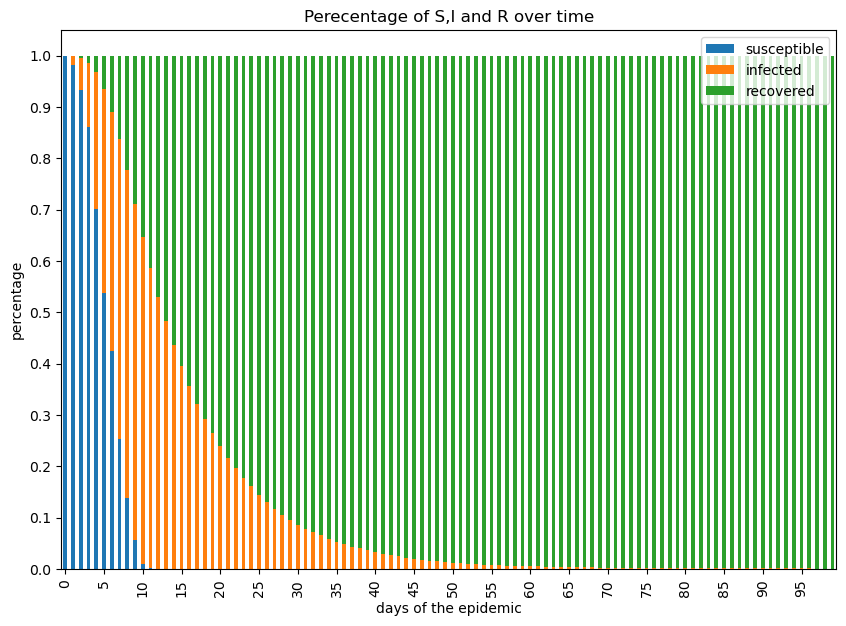

In [6]:
# visualize perecentages over time

df.plot(kind='bar', stacked=True,title='Perecentage of S,I and R over time',figsize=(10,7))
plt.locator_params(nbins=20)
plt.xlabel("days of the epidemic")
plt.ylabel("percentage")
plt.show()

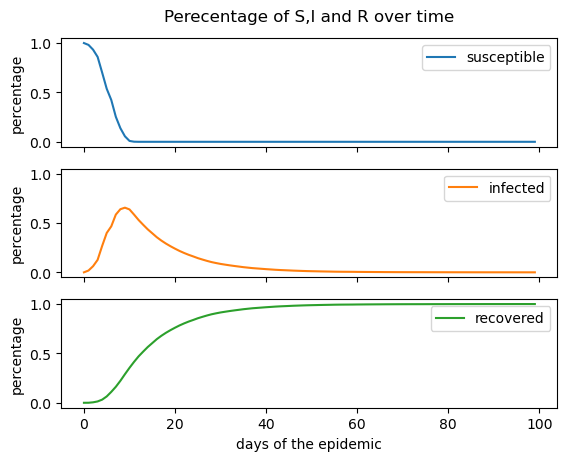

In [7]:

axes = df.plot(rot=0, subplots=True, sharey=True, ylabel='percentage')
plt.xlabel("days of the epidemic")
plt.title('Perecentage of S,I and R over time', pad=200)
plt.show()

In [8]:
# how long until 60% are infected
inf_60 = df.index[df['infected'] >= 0.6].tolist()
print('It takes {} days until 60% are infected.'.format(inf_60[0]))

# how long until 60% are recovered
inf_60 = df.index[df['recovered'] >= 0.6].tolist()
print('It takes {} days until 60% are infected.'.format(inf_60[0]))

It takes 8 days until 60% are infected.
It takes 15 days until 60% are infected.


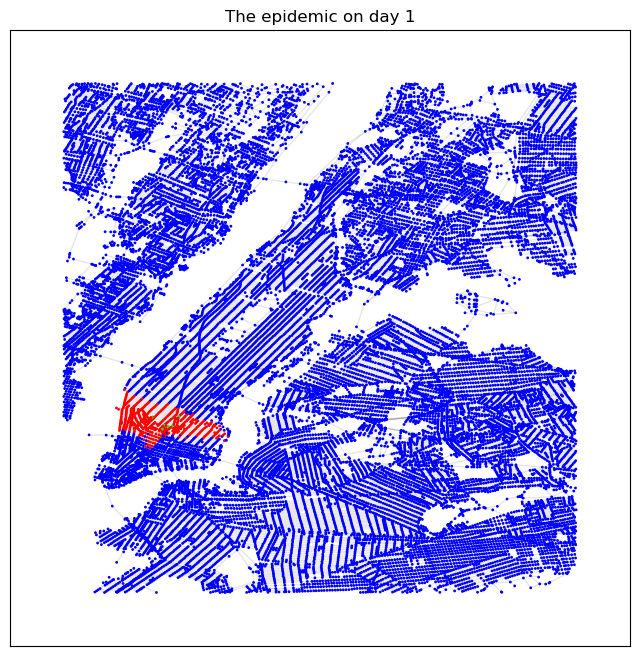

In [9]:
def status_at_time(graph, sir, t): 
    node_status = []
    for node in graph.nodes():
        node_status.append(sir.get_node_status(node, t))
    return node_status

# use coordinates to visualize graph

positions = nx.get_node_attributes(G, 'coordinates')
status = status_at_time(G, sir, 1)

fig, ax = plt.subplots(figsize=(8,8))
ax = nx.draw_networkx_nodes(G, positions,G.nodes, node_color=status, node_size=1, label=status, cmap='brg')
ax = nx.draw_networkx_edges(G,positions,  alpha=0.2, edge_color= 'grey')
plt.title('The epidemic on day 1')
plt.show()


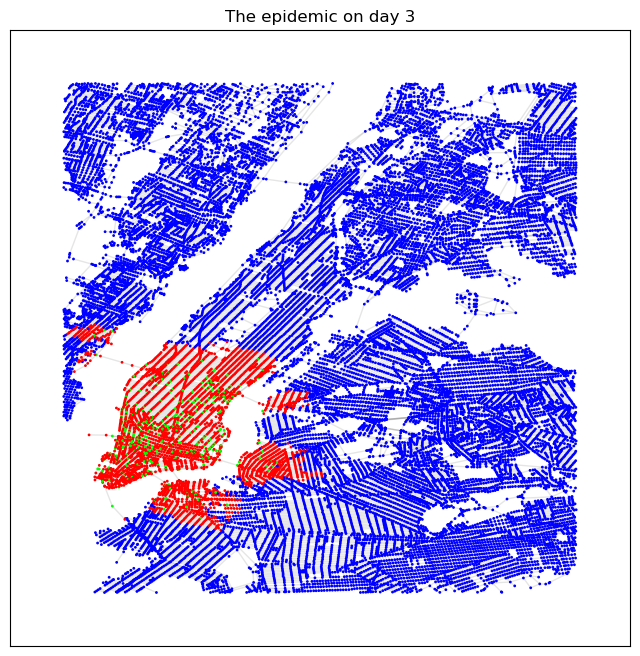

In [10]:
status = status_at_time(G, sir, 3)

fig, ax = plt.subplots(figsize=(8,8))
ax = nx.draw_networkx_nodes(G, positions,G.nodes, node_color=status, node_size=1, label=status, cmap='brg')
ax = nx.draw_networkx_edges(G,positions,  alpha=0.2, edge_color= 'grey')
plt.title('The epidemic on day 3')
plt.show()

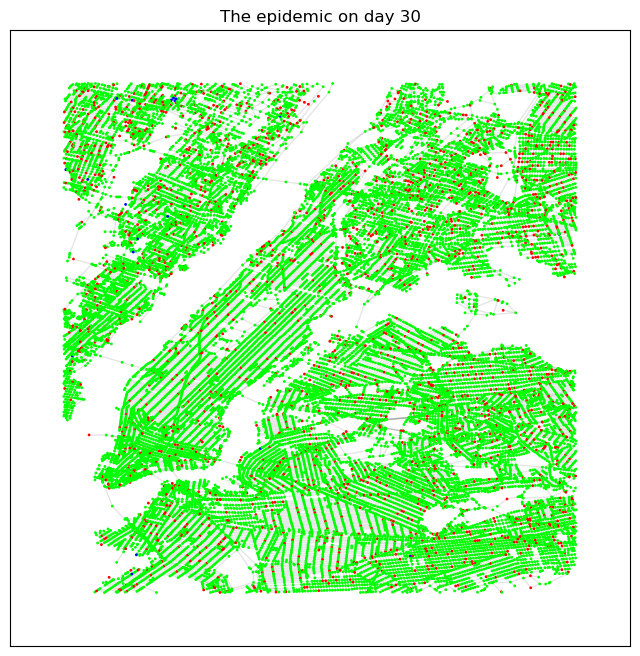

In [11]:
status = status_at_time(G, sir, 30)

fig, ax = plt.subplots(figsize=(8,8))
ax = nx.draw_networkx_nodes(G, positions,G.nodes, node_color=status, node_size=1, label=status, cmap='brg')
ax = nx.draw_networkx_edges(G,positions,  alpha=0.2, edge_color= 'grey')
plt.title('The epidemic on day 30')
plt.show()



---

### 2.3.1 Stop the apocalypse!

#### Exercise 2.10: Strategy 1

In [18]:
# budget of 1000 edges to remove to stop epidemic
import random
import numpy as np
from collections import Counter

random.seed(1)

# simulate ten times
NUM_SIMULATIONS = 10

# remove 1000 edges at random
edges_to_remove = random.sample(G.edges, 1000)
G_smaller = G.copy()
G_smaller.remove_edges_from(edges_to_remove)

num_s = []
num_i = []
num_r = []

for i in range(NUM_SIMULATIONS):
    # select source node at random
    source = random.randint(0, len(G_smaller.nodes())-1)

    # random delay rate of infection beta = 10.0
    # random delay rate of recovery beta = 0.1

    sir = epidemics_helper.SimulationSIR(G_smaller, beta=10.0, gamma=0.1)
    sir.launch_epidemic(source=source, max_time=100.0)

    status = status_at_time(G_smaller, sir, 30)
    c = Counter(status)
   
    num_s.append(c[0])
    num_i.append(c[1])
    num_r.append(c[2])


print('On average {} are healthy, {} are infected and {} are recovered on day 30 of the pandemic.'.format(np.mean(num_s),np.mean(num_i),np.mean(num_r)))
print('This means that on average {:%} stay healthy.'.format(np.mean(num_s)/ len(G_smaller) ))

Epidemic spreading... 3.78 days elapsed | 74.8% susceptible, 21.7% infected, 3.5% recovered

C:\Users\ann-k\AppData\Local\Temp\ipykernel_22228\4113380014.py:12: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges, 1000)


Epidemic stopped after 101.07 days | 101.07 days elapsed | 0.6% susceptible, 0.0% infected, 99.3% recovered
Epidemic stopped after 102.48 days | 102.48 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Epidemic stopped after 100.62 days | 100.62 days elapsed | 0.6% susceptible, 0.0% infected, 99.4% recovered
Epidemic stopped after 101.51 days | 101.51 days elapsed | 0.6% susceptible, 0.0% infected, 99.4% recovered
Epidemic stopped after 102.46 days | 102.46 days elapsed | 0.5% susceptible, 0.0% infected, 99.5% recovered
Epidemic stopped after 100.33 days | 100.33 days elapsed | 0.6% susceptible, 0.0% infected, 99.4% recovered
Epidemic stopped after 121.02 days | 121.02 days elapsed | 0.7% susceptible, 0.0% infected, 99.3% recovered
Epidemic stopped after 101.36 days | 101.36 days elapsed | 0.6% susceptible, 0.0% infected, 99.4% recovered
Epidemic stopped after 100.08 days | 100.08 days elapsed | 0.6% susceptible, 0.0% infected, 99.4% recovered
Epidemic stopped after 100.1

In [17]:
# budget of 10000 edges to remove to stop epidemic

random.seed(1)
# simulate ten times
NUM_SIMULATIONS = 10

# remove 10000 edges at random
edges_to_remove = random.sample(G.edges, 10000)
G_smaller = G.copy()
G_smaller.remove_edges_from(edges_to_remove)

num_s = []
num_i = []
num_r = []

for i in range(NUM_SIMULATIONS):
    # select source node at random
    source = random.randint(0, len(G_smaller.nodes())-1)

    # random delay rate of infection beta = 10.0
    # random delay rate of recovery beta = 0.1


    sir = epidemics_helper.SimulationSIR(G_smaller, beta=10.0, gamma=0.1)
    sir.launch_epidemic(source=source, max_time=100.0)
   
    status = status_at_time(G_smaller, sir, 30)
    c = Counter(status)
   
    num_s.append(c[0])
    num_i.append(c[1])
    num_r.append(c[2])
    
print('On average {} are healthy, {} are infected and {} are recovered on day 30 of the pandemic.'.format(np.mean(num_s),np.mean(num_i),np.mean(num_r)))
print('This means that on average {:%} stay healthy.'.format(np.mean(num_s)/ len(G_smaller) ))

C:\Users\ann-k\AppData\Local\Temp\ipykernel_22228\1824798852.py:8: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  edges_to_remove = random.sample(G.edges, 10000)


Epidemic stopped after 95.60 days | 95.60 days elapsed | 83.3% susceptible, 0.0% infected, 16.7% recovered
Epidemic stopped after 101.16 days | 101.16 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 101.83 days | 101.83 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 73.22 days | 73.22 days elapsed | 93.6% susceptible, 0.0% infected, 6.4% recovered
Epidemic stopped after 134.18 days | 134.18 days elapsed | 58.4% susceptible, 0.0% infected, 41.6% recovered
Epidemic stopped after 8.38 days | 8.38 days elapsed | 100.0% susceptible, 0.0% infected, 0.0% recovered
Epidemic stopped after 108.13 days | 108.13 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 85.66 days | 85.66 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 92.58 days | 92.58 days elapsed | 83.4% susceptible, 0.0% infected, 16.6% recovered
Epidemic stopped after 100.95 da

In [14]:
print('This means that on average {:%} stay healthy.'.format(np.mean(num_s)/ len(G_smaller)))

This means that on average 70.868925% stay healthy.


If we increase the budget of removed edges the average number of people who stay healthy increases, while the number of infected and recovered people decreases. 

#### Exercise 2.11: Strategy 2

In [15]:
"""
A local bridge is an edge whose endpoints have no common neighbors.
That is, the edge is not part of a triangle in the graph.
(https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.bridges.local_bridges.html)
"""

bridges = list(nx.local_bridges(G))
bridges.sort(key=lambda a: a[2], reverse= True) # sort by span (length of shortest path if bridge is removed)
G_without_bridges = G.copy()

NUM_EDGES_REMOVED = 2500
if NUM_EDGES_REMOVED < len(bridges):
    G_without_bridges.remove_edges_from(bridges[:NUM_EDGES_REMOVED])
else:
    # remove the 2500 local bridges with the longest shortest paths
    G_without_bridges.remove_edges_from(bridges)
    

num_s = []
num_i = []
num_r = []

for i in range(NUM_SIMULATIONS):

    # select source node at random
    source = random.randint(0, len(G_without_bridges.nodes())-1)

    sir = epidemics_helper.SimulationSIR(G_without_bridges, beta=10.0, gamma=0.1)
    sir.launch_epidemic(source=source, max_time=100.0)
   
    status = status_at_time(G_smaller, sir, 30)
    c = Counter(status)
   
    num_s.append(c[0])
    num_i.append(c[1])
    num_r.append(c[2])

print('On average {} are healthy, {} are infected and {} are recovered on day 30 of the pandemic.'.format(np.mean(num_s),np.mean(num_i),np.mean(num_r)))
print('This means that on average {:%} stay healthy.'.format(np.mean(num_s)/ len(G_without_bridges) ))

Epidemic stopped after 106.14 days | 106.14 days elapsed | 86.2% susceptible, 0.0% infected, 13.8% recovered
Epidemic stopped after 85.09 days | 85.09 days elapsed | 83.6% susceptible, 0.0% infected, 16.4% recovered
Epidemic stopped after 95.67 days | 95.67 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 86.88 days | 86.88 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 79.02 days | 79.02 days elapsed | 83.8% susceptible, 0.0% infected, 16.2% recovered
Epidemic stopped after 94.85 days | 94.85 days elapsed | 58.0% susceptible, 0.0% infected, 42.0% recovered
Epidemic stopped after 101.69 days | 101.69 days elapsed | 83.8% susceptible, 0.0% infected, 16.2% recovered
Epidemic stopped after 88.41 days | 88.41 days elapsed | 86.2% susceptible, 0.0% infected, 13.8% recovered
Epidemic stopped after 105.39 days | 105.39 days elapsed | 86.2% susceptible, 0.0% infected, 13.8% recovered
Epidemic stopped after 88.65 da

In our implementation 74.18% stay healthy on average.

In [16]:
num_comp_G = nx.number_connected_components(G) 
num_comp_s = nx.number_connected_components(G_smaller)
num_comp_G_b = nx.number_connected_components(G_without_bridges)

print("The original graph has {} component. With the random removal of edges we increase this number to {}. With the removal of local bridges in an ordered sequence we can increase the number even further to {}".format(num_comp_G, num_comp_s, num_comp_G_b))

The original graph has 1 component. With the random removal of edges we increase this number to 903. With the removal of local bridges in an ordered sequence we can increase the number even further to 2349
